### **Bilinear Fusion CNNs for Multi-Label Facial Emotion Recognition**

Set up for the project

In [147]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft as fft
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim
from torch.amp import GradScaler, autocast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, coverage_error, average_precision_score,roc_auc_score
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.io
import numpy as np
import ast
import os
import copy
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import ResNet18_Weights
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import transforms
from torchvision.models.resnet import ResNet, BasicBlock
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.models.resnet import resnet18
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [95]:
feature_dir = "/content/drive/MyDrive/multi/RAF-DB/compound/Feature"

In [96]:
# List of feature files
feature_files = ['HOG.mat', 'Gabor.mat', 'baseDCNN.mat', 'DLP-CNN.mat']

for file_name in feature_files:
    file_path = os.path.join(feature_dir, file_name)
    if not os.path.exists(file_path):
        print(f"{file_name} not found!")
        continue
    content = scipy.io.loadmat(file_path)
    print(f"Keys in {file_name}: {content.keys()}")


Keys in HOG.mat: dict_keys(['__header__', '__version__', '__globals__', 'HOG_train', 'HOG_test'])
Keys in Gabor.mat: dict_keys(['__header__', '__version__', '__globals__', 'GAB_train', 'GAB_test'])
Keys in baseDCNN.mat: dict_keys(['__header__', '__version__', '__globals__', 'baseDCNN_train', 'baseDCNN_test'])
Keys in DLP-CNN.mat: dict_keys(['__header__', '__version__', '__globals__', 'DLP_train', 'DLP_test'])


In [97]:
# Path to the zip file and target extraction directory
zip_path = "/content/drive/MyDrive/multi/RAF-DB/compound/Image/aligned.zip"
extract_dir = "/content/drive/MyDrive/multi/RAF-DB/compound/Image/aligned_extracted"

# Extract the zip file
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extracted {zip_path} to {extract_dir}")
else:
    print(f"Images already extracted to {extract_dir}")

Images already extracted to /content/drive/MyDrive/multi/RAF-DB/compound/Image/aligned_extracted


Multi-Hot Encoding

In [98]:
# Configuration
num_classes = 6
img_size = 224
use_rgb = True
augmentation = True
normalize = True

# 0: Surprise
# 1: Fear
# 2: Disgust
# 3: Happiness
# 4: Sadness
# 5: Anger

# Emotion mapping
emotion_mapping = {
    1: [0, 3],    # Happily Surprised -> Surprise, Happiness
    2: [2, 3],    # Happily Disgusted -> Disgust, Happiness
    3: [1, 4],    # Sadly Fearful -> Fear, Sadness
    4: [5, 4],    # Sadly Angry -> Anger, Sadness
    5: [0, 4],    # Sadly Surprised -> Surprise, Sadness
    6: [2, 4],    # Sadly Disgusted -> Disgust, Sadness
    7: [1, 5],    # Fearfully Angry -> Fear, Anger
    8: [1, 0],    # Fearfully Surprised -> Fear, Surprise
    9: [5, 0],    # Angrily Surprised -> Anger, Surprise
    10: [5, 2],   # Angrily Disgusted -> Anger, Disgust
    11: [2, 0],   # Disgustedly Surprised -> Disgust, Surprise
    12: [1, 2]    # Fearfully Disgusted
}

# Paths
original_labels_path = '/content/drive/MyDrive/multi/RAF-DB/compound/EmoLabel/list_patition_label.txt'
image_folder = '/content/drive/MyDrive/multi/RAF-DB/images'
train_labels_path = '/content/drive/MyDrive/multi/RAF-DB/compound/EmoLabel/preprocessed_partition_label_train.csv'
val_labels_path = '/content/drive/MyDrive/multi/RAF-DB/compound/EmoLabel/preprocessed_partition_label_val.csv'
test_labels_path = '/content/drive/MyDrive/multi/RAF-DB/compound/EmoLabel/preprocessed_partition_label_test.csv'

# Read the original label file
df = pd.read_csv(original_labels_path, sep=' ', header=None, names=['image', 'original_label'])

# Initialize multi-hot encoded labels
multi_hot_labels = []
for _, row in df.iterrows():
    orig_label = row['original_label']
    mapped_emotions = emotion_mapping.get(orig_label, [])
    multi_hot = [0] * num_classes
    for emotion in mapped_emotions:
        if 0 <= emotion < num_classes:
            multi_hot[emotion] = 1
    multi_hot_labels.append(multi_hot)

# Add multi-hot labels to the DataFrame
df['multi_hot'] = multi_hot_labels

# Separate training and testing sets based on image names
train_df = df[df['image'].str.startswith('train_')].reset_index(drop=True)
test_df = df[df['image'].str.startswith('test_')].reset_index(drop=True)

# Create validation set from training data
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['multi_hot'])

# Function to preprocess images
def preprocess_images(df, image_folder, img_size, use_rgb, normalize):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(image_folder, row['image'])
        if os.path.exists(img_path):
            # Read the image
            img = cv2.imread(img_path)
            if not use_rgb:  # Convert to grayscale if needed
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = np.expand_dims(img, axis=-1)  # Add channel dimension
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize the image
            img = cv2.resize(img, (img_size, img_size))

            # Normalize the image
            if normalize:
                img = img / 255.0

            images.append(img)
            labels.append(row['multi_hot'])
    return np.array(images), np.array(labels)

# Preprocess images for train, validation, and test sets
train_images, train_labels = preprocess_images(train_df, image_folder, img_size, use_rgb, normalize)
val_images, val_labels = preprocess_images(val_df, image_folder, img_size, use_rgb, normalize)
test_images, test_labels = preprocess_images(test_df, image_folder, img_size, use_rgb, normalize)

processed_dir = '/content/drive/MyDrive/multi/RAF-DB/processed/'
os.makedirs(processed_dir, exist_ok=True)

# Save the preprocessed datasets
np.save(os.path.join(processed_dir, 'train_images.npy'), train_images)
np.save(os.path.join(processed_dir, 'train_labels.npy'), train_labels)
np.save(os.path.join(processed_dir, 'val_images.npy'), val_images)
np.save(os.path.join(processed_dir, 'val_labels.npy'), val_labels)
np.save(os.path.join(processed_dir, 'test_images.npy'), test_images)
np.save(os.path.join(processed_dir, 'test_labels.npy'), test_labels)

# Data Augmentation
if augmentation:
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

Custom Dataset Class

In [99]:
num_classes = 6

class RAFDataset(Dataset):
    def __init__(self, image_dir, label_file, transform_global=None, transform_local=None):
        """
        Initialize RAFDataset with global and local transformations.
        :param image_dir: Directory where images are stored.
        :param label_file: Path to the CSV file containing labels.
        :param transform_global: Transformations to apply to global crops.
        :param transform_local: Transformations to apply to local crops.
        """
        self.image_dir = image_dir
        self.transform_global = transform_global or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.transform_local = transform_local or transforms.Compose([
            transforms.Resize((200, 200)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Load the labels
        self.data = pd.read_csv(label_file)
        self.images = self.data['image'].tolist()
        self.labels = [eval(label) for label in self.data['multi_hot'].tolist()]

        # Check valid paths
        self.image_paths = [os.path.join(image_dir, img) for img in self.images]
        self.image_paths, self.labels = zip(*[
            (path, label) for path, label in zip(self.image_paths, self.labels) if os.path.exists(path)
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Load and transform images.
        :param idx: Index of the data point.
        :return: Dictionary containing global image, local image, and labels.
        """
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
        except Exception as e:
            raise ValueError(f"Error loading image {self.image_paths[idx]}: {e}")

        W, H = image.size
        # Define global and local crops
        global_image = image.crop((0, 0, W // 2, H))
        local_image = image.crop((W // 2, 0, W, H))

        if self.transform_global:
            global_image = self.transform_global(global_image)
        if self.transform_local:
            local_image = self.transform_local(local_image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return {
            "global_image": global_image,
            "local_image": local_image,
            "label": label
        }

#### Model Definitions

##### Simplified Bilinear CNN

In [8]:
# ResNet10 Backbone
class ResNet10(ResNet):
    def __init__(self, num_classes=6, pretrained=False):
        super(ResNet10, self).__init__(BasicBlock, [1, 1, 1, 1])  # ResNet10 structure

        self.fc = nn.Identity()  # Remove the fully connected layer

# Modified Fusion Layer with Increased Dropout
class MultiLabelEmotionModel(nn.Module):

    def __init__(self, num_classes=6):
        super(MultiLabelEmotionModel, self).__init__()

        self.backbone = resnet18(weights="IMAGENET1K_V1")

        self.backbone.fc = nn.Identity()

        self.fusion = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased Dropout
            nn.Linear(512, num_classes),
        )

    def forward(self, global_image, local_image):

        # Extract global and local features
        global_features = self.backbone(global_image)
        local_features = self.backbone(local_image)

        fused_features = global_features * local_features

        return self.fusion(fused_features)

##### Standard Bilinear-CNN model with Compact Bilinear Sum-pooling

In [52]:
class ResNet10(ResNet):
    def __init__(self, num_classes=6, pretrained=False):
        super(ResNet10, self).__init__(BasicBlock, [1, 1, 1, 1])  # ResNet10 structure

        # Remove the fully connected layer
        self.fc = nn.Identity()

        if pretrained:
            # Load weights from ResNet18 (or adapt as needed)
            state_dict = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True).state_dict()
            self.load_state_dict(state_dict, strict=False)

class BilinearSumPoolingModel(nn.Module):
    def __init__(self, num_classes=6, pretrained=False):
        super(BilinearSumPoolingModel, self).__init__()

        # Backbone: ResNet10 (for both global and local branches)
        self.backbone_global = ResNet10(pretrained=pretrained)
        self.backbone_local = ResNet10(pretrained=pretrained)

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(512, 512),  # Reduce dimensions post pooling
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, global_image, local_image):
        # Extract features
        global_features = self.backbone_global(global_image)  # [B, 512]
        local_features = self.backbone_local(local_image)    # [B, 512]

        # Bilinear pooling (element-wise multiplication)
        fused_features = global_features * local_features  # [B, 512]

        # Sum pooling (no spatial dimensions here, as features are already reduced)
        # If ResNet10 includes spatial dimensions (e.g., [B, 512, H, W]), add sum pooling:
        # fused_features = fused_features.sum(dim=[2, 3])  # Uncomment if needed

        # Classify
        logits = self.fusion(fused_features)

        return logits


##### HOG-Classifier

In [125]:
file_path_hog = os.path.join(feature_dir, 'HOG.mat')

# Load HOG features
hog_data = scipy.io.loadmat(file_path_hog)

# Extract train and test features
hog_train = hog_data['HOG_train']  # Training HOG features
hog_test = hog_data['HOG_test']    # Testing HOG features

In [148]:
train_labels = np.array(train_df['multi_hot'].tolist())
test_labels = np.array(test_df['multi_hot'].tolist())

In [149]:
# Convert labels to PyTorch tensors
train_labels_tensor_hog = torch.tensor(train_labels, dtype=torch.float32)
test_labels_tensor_hog = torch.tensor(test_labels, dtype=torch.float32)

# Convert HOG features to PyTorch tensors
hog_train_tensor = torch.tensor(hog_train, dtype=torch.float32)
hog_test_tensor = torch.tensor(hog_test, dtype=torch.float32)


In [150]:
# For training set
min_train_size = min(hog_train_tensor.size(0), train_labels_tensor_hog.size(0))
hog_train_tensor = hog_train_tensor[:min_train_size]
train_labels_tensor_hog = train_labels_tensor_hog[:min_train_size]

# For testing set
min_test_size = min(hog_test_tensor.size(0), test_labels_tensor_hog.size(0))
hog_test_tensor = hog_test_tensor[:min_test_size]
test_labels_tensor_hog = test_labels_tensor_hog[:min_test_size]


##### Baseline Model

In [61]:
class BaselineAdditiveModel(nn.Module):
    """
    A baseline model for multi-label classification using two ResNet10 backbones (global and local).
    Combines global and local features via element-wise addition and applies a classification head.
    """
    def __init__(self, num_classes=6, pretrained=False):
        super(BaselineAdditiveModel, self).__init__()

        # Global and Local Backbones: ResNet10
        self.backbone_global = ResNet10(pretrained=pretrained)
        self.backbone_local = ResNet10(pretrained=pretrained)

        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),  # Reduce feature dimensions
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output layer for multi-label classification
        )

    def forward(self, global_image, local_image):
        """
        Forward pass of the model.
        :param global_image: Input tensor for global image [B, C, H, W].
        :param local_image: Input tensor for local image [B, C, H, W].
        :return: Logits for multi-label classification [B, num_classes].
        """
        # Extract features from both backbones
        global_features = self.backbone_global(global_image)  # [B, 512]
        local_features = self.backbone_local(local_image)     # [B, 512]

        # Combine features via element-wise addition
        combined_features = global_features + local_features  # [B, 512]

        # Pass through the classifier
        logits = self.classifier(combined_features)

        return logits


In [103]:
# Dataset Augmentation and Transformations
train_dataset = RAFDataset(
    image_dir="/content/drive/MyDrive/multi/RAF-DB/compound/Image/aligned_extracted/aligned",
    label_file="/content/drive/MyDrive/multi/RAF-DB/compound/EmoLabel/preprocessed_partition_label_train.csv",
    transform_global=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    transform_local=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomCrop((200, 200)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)


test_dataset = RAFDataset(
    image_dir="/content/drive/MyDrive/multi/RAF-DB/compound/Image/aligned_extracted/aligned",
    label_file="/content/drive/MyDrive/multi/RAF-DB/compound/EmoLabel/preprocessed_partition_label_test.csv",
    transform_global=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    transform_local=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

train_labels = np.array([label for label in train_dataset.labels])
label_counts = np.sum(train_labels, axis=0)
total_labels = np.sum(label_counts)
label_counts = np.where(label_counts == 0, 1, label_counts)  # Avoid division by zero
class_weights = total_labels / (len(label_counts) * label_counts)

# Weighted Sampler for Class Balancing
weights = [sum([class_weights[i] for i, val in enumerate(label) if val]) for label in train_labels]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [104]:
# Smooth Label BCE Loss
class SmoothLabelBCEWithLogitsLoss(nn.Module):
    def __init__(self, smooth_factor=0.1, class_weights=None):
        super(SmoothLabelBCEWithLogitsLoss, self).__init__()
        self.smooth_factor = smooth_factor
        self.class_weights = class_weights

    def forward(self, logits, targets):
        smooth_targets = targets * (1 - self.smooth_factor) + self.smooth_factor / targets.size(1)

        loss = F.binary_cross_entropy_with_logits(logits, smooth_targets, weight=self.class_weights)

        return loss

In [105]:
# Evaluation Function
def evaluate_model(model, dataloader, device):

    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for batch in dataloader:
            global_images = batch["global_image"].to(device)
            local_images = batch["local_image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(global_images, local_images)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    # Binarize predictions at threshold 0.5
    preds_binary = (all_preds > 0.5).astype(int)

    accuracy = accuracy_score(all_labels, preds_binary)
    recall = recall_score(all_labels, preds_binary, average='macro', zero_division=0)
    f1_macro = f1_score(all_labels, preds_binary, average='macro')
    f1_micro = f1_score(all_labels, preds_binary, average='micro')
    hl = hamming_loss(all_labels, preds_binary)
    avg_prec = average_precision_score(all_labels, all_preds, average='macro')
    cov = coverage_error(all_labels, all_preds)
    auc_macro = roc_auc_score(all_labels, all_preds, average='macro')
    auc_micro = roc_auc_score(all_labels, all_preds, average='micro')

    return accuracy, recall, f1_macro, f1_micro, hl, avg_prec, cov, auc_macro, auc_micro

In [106]:
# Training with Best Model Saving Logic
# Training with Metric Tracking
def train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=50
):
    scaler = torch.amp.GradScaler()
    best_val_f1_macro = 0.0
    best_model_path = "/content/drive/MyDrive/best_model.pth"

    # Metrics storage
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "train_f1_macro": [],
        "val_f1_macro": [],
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            global_images = batch["global_image"].to(device)
            local_images = batch["local_image"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type="cuda"):  # Updated mixed precision
                outputs = model(global_images, local_images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        scheduler.step()

        # Calculate average training loss
        train_loss = running_loss / len(train_loader)

        # Evaluate on train and validation data
        train_metrics = evaluate_model(model, train_loader, device)
        val_metrics = evaluate_model(model, test_loader, device)

        # train_accuracy, train_f1_macro, _, train_hl = train_metrics
        # val_accuracy, val_f1_macro, _, val_hl = val_metrics

        train_accuracy, recall, train_f1_macro, f1_micro, train_hl, avg_prec, cov, auc_macro, auc_micro = train_metrics
        val_accuracy, recall, val_f1_macro, f1_micro, val_hl, avg_prec, cov, auc_macro, auc_micro = val_metrics

        # Append metrics to history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss := train_loss)  # Validation loss proxy (if unavailable)
        history["train_accuracy"].append(train_accuracy)
        history["val_accuracy"].append(val_accuracy)
        history["train_f1_macro"].append(train_f1_macro)
        history["val_f1_macro"].append(val_f1_macro)

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Train F1 Macro: {train_f1_macro:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f} | Validation F1 Macro: {val_f1_macro:.4f} | Validation Hamming Loss: {val_hl:.4f}")

        # Save the best model based on validation F1 Macro
        if val_f1_macro > best_val_f1_macro:
            best_val_f1_macro = val_f1_macro
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with F1 Macro: {val_f1_macro:.4f}")

    print(f"Best model saved at {best_model_path}")
    return history

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)

criterion = SmoothLabelBCEWithLogitsLoss(smooth_factor=0.1, class_weights=class_weights_tensor)

simplified_model = MultiLabelEmotionModel(num_classes=6).to(device)
simplified_optimizer = torch.optim.AdamW(simplified_model.parameters(), lr=1e-3, weight_decay=1e-5)
simplified_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(simplified_optimizer, T_0=10, T_mult=2, eta_min=1e-6)

sum_model = BilinearSumPoolingModel(num_classes=6).to(device)
sum_optimizer = torch.optim.AdamW(sum_model.parameters(), lr=1e-4, weight_decay=1e-5)
sum_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(sum_optimizer, T_0=10, T_mult=2, eta_min=1e-6)


baseline_model = BaselineAdditiveModel(num_classes=6, pretrained=False).to(device)
baseline_optimizer = torch.optim.AdamW(baseline_model.parameters(), lr=1e-4, weight_decay=1e-5)
baseline_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(baseline_optimizer, T_0=10, T_mult=2, eta_min=1e-6)

#### Training

In [58]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

##### Simplified B-CNN Model

In [152]:
# Train the model
hist = train_model(simplified_model, train_loader, test_loader, criterion, simplified_optimizer, simplified_scheduler, device, num_epochs=50)

Epoch [1/50]
Train Loss: 0.5586 | Train Accuracy: 0.1436 | Train F1 Macro: 0.4459
Validation Accuracy: 0.1477 | Validation F1 Macro: 0.4300 | Validation Hamming Loss: 0.2447
Best model saved with F1 Macro: 0.4300
Epoch [2/50]
Train Loss: 0.4864 | Train Accuracy: 0.2802 | Train F1 Macro: 0.5627
Validation Accuracy: 0.3005 | Validation F1 Macro: 0.5779 | Validation Hamming Loss: 0.2077
Best model saved with F1 Macro: 0.5779
Epoch [3/50]
Train Loss: 0.4508 | Train Accuracy: 0.3533 | Train F1 Macro: 0.6141
Validation Accuracy: 0.3030 | Validation F1 Macro: 0.5804 | Validation Hamming Loss: 0.2123
Best model saved with F1 Macro: 0.5804
Epoch [4/50]
Train Loss: 0.4282 | Train Accuracy: 0.4035 | Train F1 Macro: 0.6500
Validation Accuracy: 0.3598 | Validation F1 Macro: 0.6160 | Validation Hamming Loss: 0.2115
Best model saved with F1 Macro: 0.6160
Epoch [5/50]
Train Loss: 0.4097 | Train Accuracy: 0.4472 | Train F1 Macro: 0.6863
Validation Accuracy: 0.4242 | Validation F1 Macro: 0.6628 | Valida

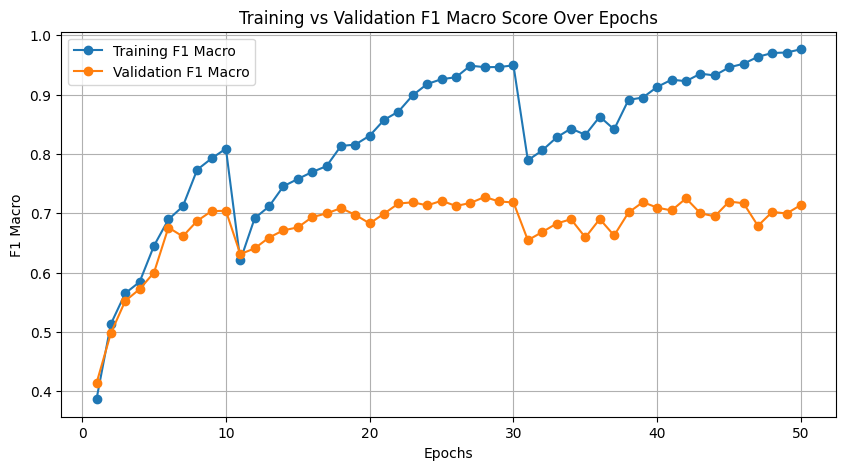

In [38]:
# Extract metrics from the history
epochs = range(1, len(hist["train_loss"]) + 1)
train_loss = hist["train_loss"]
val_loss = hist["val_loss"]
train_f1_macro = hist["train_f1_macro"]
val_f1_macro = hist["val_f1_macro"]


# Plot F1 Macro Scores
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_macro, label="Training F1 Macro", marker='o')
plt.plot(epochs, val_f1_macro, label="Validation F1 Macro", marker='o')
plt.title("Training vs Validation F1 Macro Score Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1 Macro")
plt.legend()
plt.grid()
plt.show()

##### Standard Bilinear-CNN model with Compact Bilinear Sum-pooling


In [59]:
hist_sum = train_model(sum_model, train_loader, test_loader, criterion, sum_optimizer, sum_scheduler, device, num_epochs=50)

Epoch [1/50]
Train Loss: 0.6602 | Train Accuracy: 0.0009 | Train F1 Macro: 0.1135
Validation Accuracy: 0.0013 | Validation F1 Macro: 0.0993 | Validation Hamming Loss: 0.3255
Best model saved with F1 Macro: 0.0993
Epoch [2/50]
Train Loss: 0.6353 | Train Accuracy: 0.0025 | Train F1 Macro: 0.1014
Validation Accuracy: 0.0025 | Validation F1 Macro: 0.0888 | Validation Hamming Loss: 0.3251
Epoch [3/50]
Train Loss: 0.6260 | Train Accuracy: 0.0047 | Train F1 Macro: 0.1273
Validation Accuracy: 0.0051 | Validation F1 Macro: 0.1454 | Validation Hamming Loss: 0.3171
Best model saved with F1 Macro: 0.1454
Epoch [4/50]
Train Loss: 0.6274 | Train Accuracy: 0.0253 | Train F1 Macro: 0.1948
Validation Accuracy: 0.0227 | Validation F1 Macro: 0.1997 | Validation Hamming Loss: 0.3157
Best model saved with F1 Macro: 0.1997
Epoch [5/50]
Train Loss: 0.6202 | Train Accuracy: 0.0237 | Train F1 Macro: 0.1978
Validation Accuracy: 0.0227 | Validation F1 Macro: 0.2017 | Validation Hamming Loss: 0.3138
Best model sa

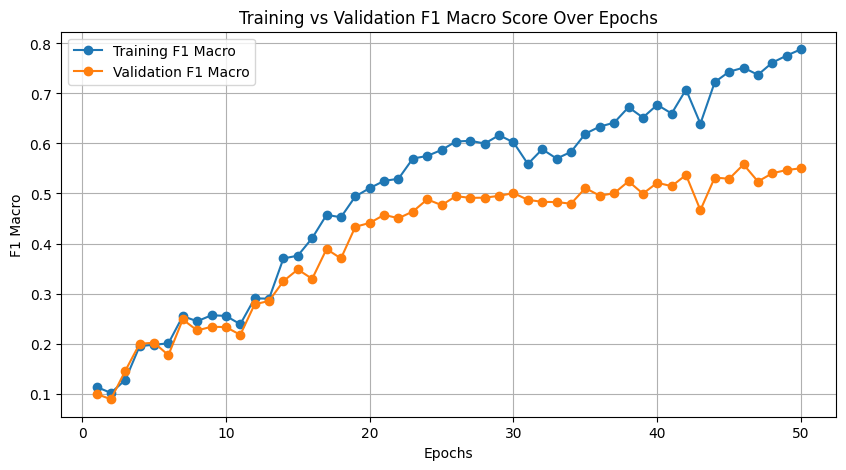

In [60]:
# Extract metrics from the history
epochs = range(1, len(hist_sum["train_loss"]) + 1)
train_loss = hist_sum["train_loss"]
val_loss = hist_sum["val_loss"]
train_f1_macro = hist_sum["train_f1_macro"]
val_f1_macro = hist_sum["val_f1_macro"]


# Plot F1 Macro Scores
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_macro, label="Training F1 Macro", marker='o')
plt.plot(epochs, val_f1_macro, label="Validation F1 Macro", marker='o')
plt.title("Training vs Validation F1 Macro Score Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1 Macro")
plt.legend()
plt.grid()
plt.show()

##### Traditional CNN (Baseline) Model

In [67]:
# Train the baseline model
history_baseline = train_model(
    baseline_model,
    train_loader,
    test_loader,
    criterion,
    baseline_optimizer,
    baseline_scheduler,
    device=device,
    num_epochs=50
)

Epoch [1/50]
Train Loss: 0.6532 | Train Accuracy: 0.0006 | Train F1 Macro: 0.1493
Validation Accuracy: 0.0000 | Validation F1 Macro: 0.1476 | Validation Hamming Loss: 0.3178
Best model saved with F1 Macro: 0.1476
Epoch [2/50]
Train Loss: 0.6390 | Train Accuracy: 0.0019 | Train F1 Macro: 0.1052
Validation Accuracy: 0.0025 | Validation F1 Macro: 0.1142 | Validation Hamming Loss: 0.3228
Epoch [3/50]
Train Loss: 0.6328 | Train Accuracy: 0.0022 | Train F1 Macro: 0.1173
Validation Accuracy: 0.0038 | Validation F1 Macro: 0.1176 | Validation Hamming Loss: 0.3262
Epoch [4/50]
Train Loss: 0.6275 | Train Accuracy: 0.0278 | Train F1 Macro: 0.1769
Validation Accuracy: 0.0278 | Validation F1 Macro: 0.1694 | Validation Hamming Loss: 0.3203
Best model saved with F1 Macro: 0.1694
Epoch [5/50]
Train Loss: 0.6261 | Train Accuracy: 0.0041 | Train F1 Macro: 0.1715
Validation Accuracy: 0.0013 | Validation F1 Macro: 0.1496 | Validation Hamming Loss: 0.3077
Epoch [6/50]
Train Loss: 0.6168 | Train Accuracy: 0.

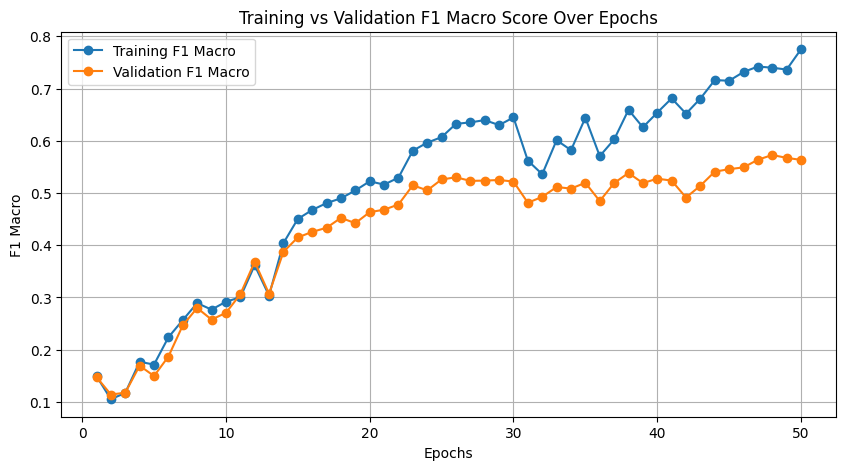

In [68]:
epochs = range(1, len(hist_sum["train_loss"]) + 1)
train_loss = history_baseline["train_loss"]
val_loss = history_baseline["val_loss"]
train_f1_macro = history_baseline["train_f1_macro"]
val_f1_macro = history_baseline["val_f1_macro"]


# Plot F1 Macro Scores
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_macro, label="Training F1 Macro", marker='o')
plt.plot(epochs, val_f1_macro, label="Validation F1 Macro", marker='o')
plt.title("Training vs Validation F1 Macro Score Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1 Macro")
plt.legend()
plt.grid()
plt.show()

##### HOG-Classifier

In [144]:
hog_train_np = hog_train_tensor.numpy()
hog_test_np = hog_test_tensor.numpy()
train_labels_np = train_labels_tensor_hog.numpy()
test_labels_np = test_labels_tensor_hog.numpy()

In [145]:
# Create and train the model
logistic_model = OneVsRestClassifier(LogisticRegression(max_iter=500, solver='lbfgs'))
logistic_model.fit(hog_train_np, train_labels_np)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=500))

In [151]:
# Training Predictions
train_preds_prob = logistic_model.predict_proba(hog_train_np)
train_preds_binary = (train_preds_prob > 0.5).astype(int)

# Validation Predictions
test_preds_prob = logistic_model.predict_proba(hog_test_np)
test_preds_binary = (test_preds_prob > 0.5).astype(int)

# Compute Metrics for Training
train_accuracy = accuracy_score(train_labels_np, train_preds_binary)
train_f1_macro = f1_score(train_labels_np, train_preds_binary, average='macro')
train_hamming_loss = hamming_loss(train_labels_np, train_preds_binary)

# Compute Metrics for Validation
val_accuracy = accuracy_score(test_labels_np, test_preds_binary)
val_f1_macro = f1_score(test_labels_np, test_preds_binary, average='macro')
val_hamming_loss = hamming_loss(test_labels_np, test_preds_binary)

# Print Metrics in Desired Format
print("Logistic Regression Results:")
print(f"Train Accuracy: {train_accuracy:.4f} | Train F1 Macro: {train_f1_macro:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f} | Validation F1 Macro: {val_f1_macro:.4f} | Validation Hamming Loss: {val_hamming_loss:.4f}")

Logistic Regression Results:
Train Accuracy: 0.4559 | Train F1 Macro: 0.7434
Validation Accuracy: 0.0568 | Validation F1 Macro: 0.2419 | Validation Hamming Loss: 0.3767


#### Inference

In [154]:
# Recreate the model architecture
simplified_model = MultiLabelEmotionModel(num_classes=6)

# Load the trained weights
simplified_model.load_state_dict(torch.load('/content/drive/MyDrive/best_model.pth'))

# Set the model to evaluation mode
simplified_model.eval().to(device)

<ipython-input-154-9adaf867e99a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simplified_model.load_state_dict(torch.load('/content/drive/MyDrive/best_model.pth'))


MultiLabelEmotionModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [157]:
# Define the emotion labels
emotion_labels = ["Surprise", "Fear", "Disgust", "Happiness", "Sadness", "Anger"]

def inference(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            global_images = batch["global_image"].to(device)
            local_images = batch["local_image"].to(device)
            labels = batch["label"].to(device)

            # Get predictions
            logits = model(global_images, local_images)
            probabilities = torch.sigmoid(logits)  # Convert logits to probabilities
            predictions = (probabilities > 0.5).int()  # Binarize predictions

            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    return all_preds, all_labels


In [158]:
# Perform inference
predictions, ground_truths = inference(simplified_model, test_loader, device)

# Calculate metrics
accuracy = accuracy_score(ground_truths, predictions)
f1_macro = f1_score(ground_truths, predictions, average='macro')
f1_micro = f1_score(ground_truths, predictions, average='micro')
hamming = hamming_loss(ground_truths, predictions)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Micro: {f1_micro:.4f}")
print(f"Hamming Loss: {hamming:.4f}")

Accuracy: 0.5013
F1 Macro: 0.7200
F1 Micro: 0.7466
Hamming Loss: 0.1665


In [159]:
# Map predictions to emotion labels
sample_index = 0  # Change index to view different samples
sample_prediction = predictions[sample_index]
sample_emotions = [emotion_labels[i] for i, val in enumerate(sample_prediction) if val == 1]

print(f"Predicted Emotions for Sample {sample_index}: {sample_emotions}")
print(f"Ground Truth Emotions for Sample {sample_index}: {[emotion_labels[i] for i, val in enumerate(ground_truths[sample_index]) if val == 1]}")


Predicted Emotions for Sample 0: ['Surprise', 'Happiness']
Ground Truth Emotions for Sample 0: ['Surprise', 'Happiness']


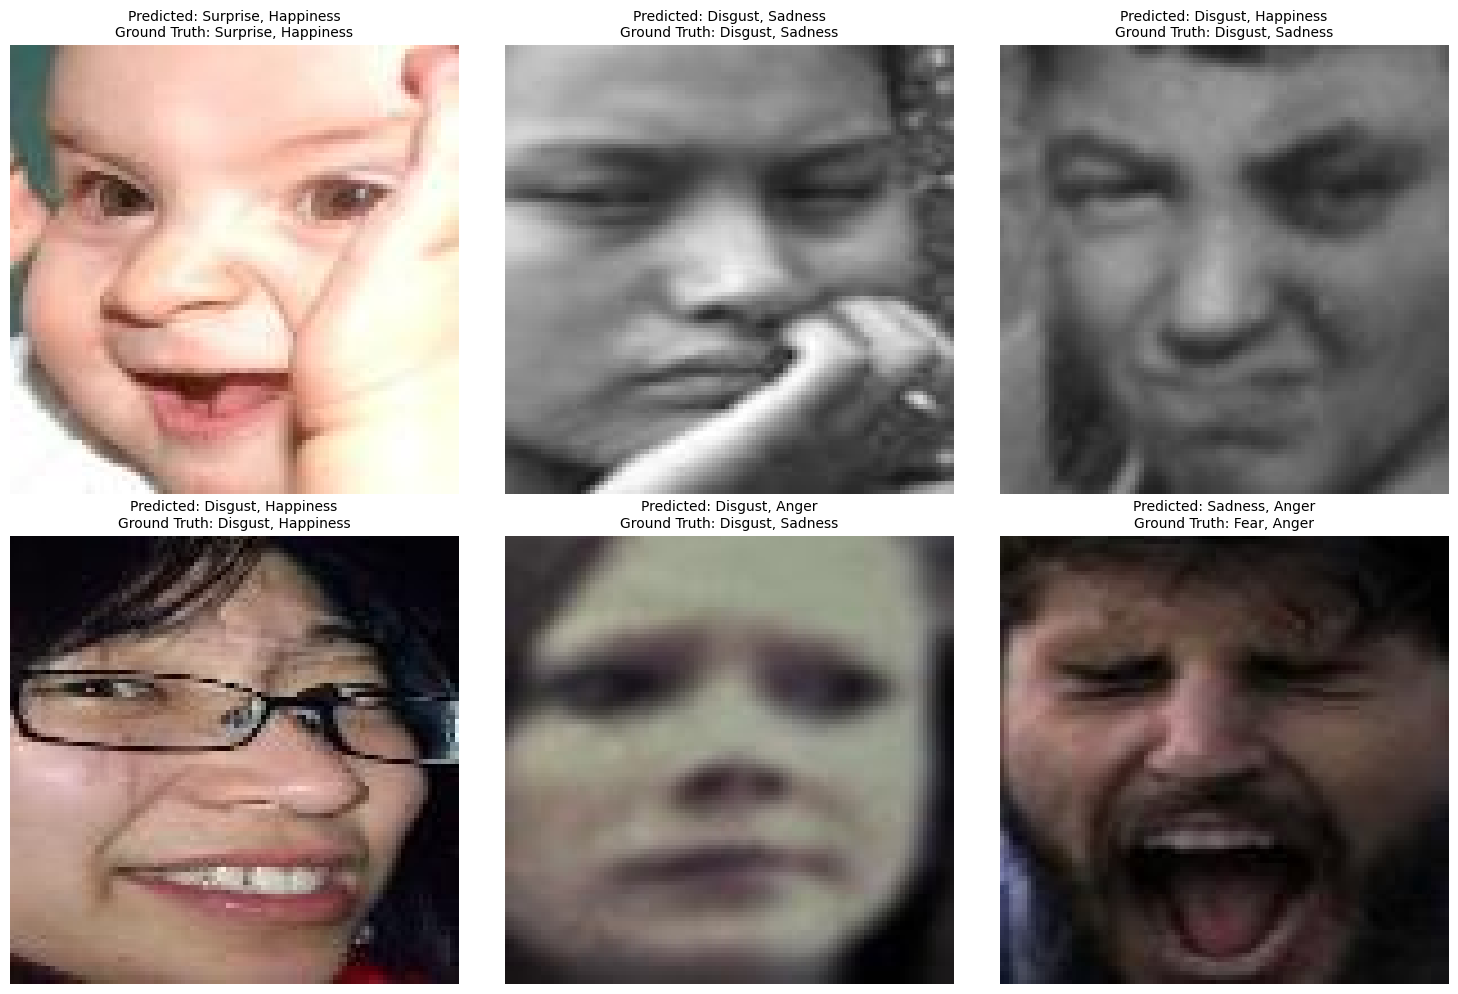

In [162]:
def visualize_predictions(model, dataloader, device, emotion_labels, num_images=6):
    """
    Visualize predictions with original images and ground truth labels.
    :param model: Trained model for inference.
    :param dataloader: DataLoader for test data.
    :param device: Device (CPU or GPU).
    :param emotion_labels: List of emotion labels.
    :param num_images: Number of images to display.
    """
    model.eval()
    images_to_display = []
    predictions_to_display = []
    ground_truths_to_display = []
    original_images = []

    # Randomly sample images from the test set
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            global_images = batch["global_image"].to(device)
            local_images = batch["local_image"].to(device)
            labels = batch["label"].cpu().numpy()
            image_paths = dataloader.dataset.image_paths  # Access original image paths

            # Get model predictions
            logits = model(global_images, local_images)
            probabilities = torch.sigmoid(logits).cpu().numpy()
            predictions = (probabilities > 0.5).astype(int)

            for i in range(len(global_images)):
                if len(images_to_display) < num_images:
                    predictions_to_display.append(predictions[i])
                    ground_truths_to_display.append(labels[i])

                    # Load the original image
                    original_path = image_paths[batch_idx * len(global_images) + i]
                    original_img = cv2.imread(original_path)
                    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
                    original_images.append(original_img)
                else:
                    break
            if len(images_to_display) >= num_images:
                break

    # Plot the images
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        if idx < len(original_images):
            original_img = original_images[idx]
            prediction = predictions_to_display[idx]
            ground_truth = ground_truths_to_display[idx]

            pred_emotions = [emotion_labels[i] for i, val in enumerate(prediction) if val == 1]
            gt_emotions = [emotion_labels[i] for i, val in enumerate(ground_truth) if val == 1]

            ax.imshow(original_img)
            ax.axis("off")
            ax.set_title(
                f"Predicted: {', '.join(pred_emotions)}\nGround Truth: {', '.join(gt_emotions)}",
                fontsize=10
            )
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize predictions for 6 random images
visualize_predictions(
    simplified_model,
    test_loader,
    device,
    emotion_labels,
    num_images=6
)